# UCM spike count distribution marginalization

Here we compare UCM models with larger number of input covariates that have been marginalized to smaller numbers of input covariates with UCM models of the smaller input spaces.

```
python3 models.py --data_type th1 --checkpoint_dir ./checkpoint/ --data_path ../data/ --cv_folds 10 --cv -1 1 2 3 5 6 8 --seeds 123 1234 12345 --batch_size 10000 --max_epochs 3000 --bin_size 40 --likelihood U-el-3 --mapping svgp-32 --x_mode hd --lr 1e-2 --jitter 1e-5 --gpu 0

python3 models.py --data_type th1 --checkpoint_dir ./checkpoint/ --data_path ../data/ --cv_folds 10 --cv -1 1 2 3 5 6 8 --seeds 123 1234 12345 --batch_size 10000 --max_epochs 3000 --bin_size 40 --likelihood U-el-3 --mapping svgp-32 --x_mode x-y --lr 1e-2 --jitter 1e-5 --gpu 0

python3 models.py --data_type th1 --checkpoint_dir ./checkpoint/ --data_path ../data/ --cv_folds 10 --cv -1 1 2 3 5 6 8 --seeds 123 1234 12345 --batch_size 10000 --max_epochs 3000 --bin_size 40 --likelihood U-el-3 --mapping svgp-32 --x_mode hd-x-y --lr 1e-2 --jitter 1e-5 --gpu 1
```

### Table of contents

1. [**Loading UCM models**](#load)
2. [**Marginalized UCM comparison**](#marg)

In [1]:
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import scipy.special as sps
import scipy.stats as scstats
import numpy as np

import sys
sys.path.append("..") # access to library
sys.path.append("../scripts/") # access to scripts
    

import neuroprob as nprb
from neuroprob import utils


device = nprb.inference.get_device(gpu=0)

import models
#import ucm_stats

import pickle


PyTorch version: 1.13.1+cu117
Using device: cuda:0


<a id='loading'></a>
## 1. Loading UCM models

Here we specify the dataset used for training and the model architecture hyperparameters. This model is the UCM fit to observed covariates ```x_mode = 'hd-w-s-pos-t'```, meaning head direction (```hd```), angular head velocity (```w```), speed (```s```), animal $x$ and $y$ position (```pos```, two dimensions), and absolute time since the start of the recording session (```t```).

In [2]:
data_path = '../data/'
data_type = 'th1'
bin_size = 40

dataset_dict = models.get_dataset(data_type, bin_size, data_path)

In [3]:
checkpoint_dir = '../scripts/checkpoint/'
batch_info = 500
training_losses = []

config_name = 'th1_U-el-3_svgp-32_X[hd-x-y]_Z[]_40K11_0d0_10f1'

full_model, training_loss, fit_dict, _ = models.load_model(
    config_name,
    checkpoint_dir,
    dataset_dict,
    batch_info,
    'cpu', 
)
training_losses.append(training_loss)


config_name = 'th1_U-el-3_svgp-32_X[hd]_Z[]_40K11_0d0_10f1'

hd_model, training_loss, _, _ = models.load_model(
    config_name,
    checkpoint_dir,
    dataset_dict,
    batch_info,
    'cpu', 
)
training_losses.append(training_loss)


# config_name = 'th1_U-el-3_svgp-32_X[x-y]_Z[]_40K11_0d0_10f1'

# xy_model, training_loss, _, _ = models.load_model(
#     config_name,
#     checkpoint_dir,
#     dataset_dict,
#     batch_info,
#     'cpu', 
# )
# training_losses.append(training_loss)

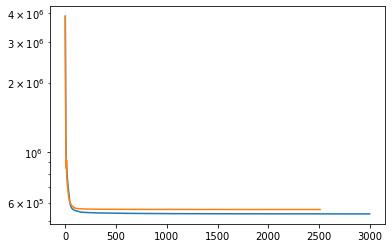

In [5]:
for training_loss in training_losses:
    plt.plot(training_loss)
    plt.yscale('log')
    
plt.show()

<a id='marg'></a>
## 2. Marginalized UCM comparison

Here we specify the dataset used for training and the model architecture hyperparameters. This model is the UCM fit to observed covariates ```x_mode = 'hd-w-s-pos-t'```, meaning head direction (```hd```), angular head velocity (```w```), speed (```s```), animal $x$ and $y$ position (```pos```, two dimensions), and absolute time since the start of the recording session (```t```).

In [ ]:
# compare to model fit only to hd
skip = 1
MC = 100
pick_neurons = [0]
batch_size = 1000
eval_steps = 100

full_model = full_model.to('cpu')  # move to GPU if possible

P_tot = utils.model.marginalize_UCM_P_count(
    full_model.mapping,
    full_model.likelihood, 
    [torch.linspace(0, 2 * np.pi, eval_steps)],
    [0],
    fit_dict['covariates'],
    batch_size,
    pick_neurons,
    MC=MC,
    sample_skip=skip,
)

full_model = full_model.to('cpu')


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# quantiles, Z scores
P_ = []
for b in range(gpr.input_group.batches):
    covariates, _ = gpr.input_group.sample_XZ(b, samples=1)  # get the training batch b
    with torch.no_grad():
        P_mc = utils.model.compute_UCM_P_count(
            gp, likelihood, covariates, list(range(neurons)), MC=30, trials=1)  # predictive posterior
    P_.append(P_mc.mean(0).cpu().numpy())  # take mean over MC samples
P = np.concatenate(P_, axis=1)  # count probabilities of shape (neurons, timesteps, count)


q = []
Z = []
trial = 0
for n in range(neurons):
    spike_binned = gpr.likelihood.all_spikes[trial, n, :].numpy()
    q_ = utils.stats.counts_to_quantiles(P[n, ...], spike_binned, rng)
    q.append(q_)

q = np.array(q)  # quantiles of shape (neurons, timesteps)

In [5]:
# compare to model fit only to speed
a = {'f': 1, 'd': 2}

for b, v in zip(a):
    print(b, v)

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
# compare to model fit only to hd-omega

In [ ]:
# compare to model fit only to position